In [17]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import pandas
import datetime as dt

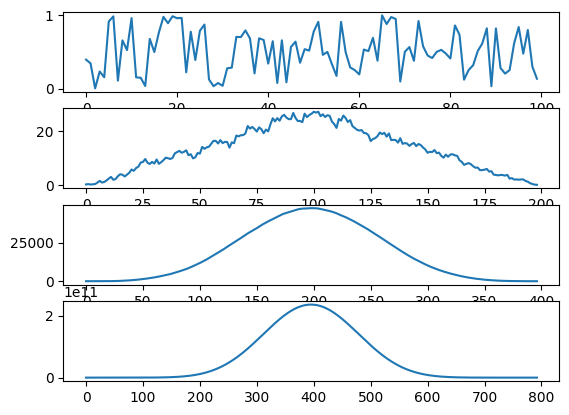

In [18]:
# Generating a random vector and applying convolution with itself.
fig, axs = plt.subplots(4)

v = np.random.random(100)
axs[0].plot(v)

for i in range(3):
    v = np.convolve(v, v)
    axs[i+1].plot(v)

In [19]:
# Multiplying two polinomials using fft. 

def poly_to_string(p):
    result = str(p[0]) 

    for (i, k) in enumerate(p[1:]):
        result += f" + {str(k)}x^{str(i+1)}"
    return result

n =  5

p = np.random.randint(size = n+1, low = 1, high= 5)
q = np.random.randint(size= n+1, low = 1, high= 5)

print("p = ", poly_to_string(p))
print("q = ", poly_to_string(q))

# First try using naive convolution.
result_convolve = np.convolve(p ,q)
print("p * q = ",poly_to_string(result_convolve))

# Then try using fft.
p_freq = np.fft.fft(np.append(p, np.zeros(n)))
q_freq = np.fft.fft(np.append(q, np.zeros(n))) 
pq_freq = p_freq * q_freq
result_fft = np.round(np.fft.ifft(pq_freq).real, 0)

print("p * q = ",poly_to_string(result_fft))

p =  3 + 3x^1 + 2x^2 + 3x^3 + 3x^4 + 3x^5
q =  4 + 1x^1 + 1x^2 + 3x^3 + 3x^4 + 4x^5
p * q =  12 + 15x^1 + 14x^2 + 26x^3 + 35x^4 + 45x^5 + 33x^6 + 29x^7 + 30x^8 + 21x^9 + 12x^10
p * q =  12.0 + 15.0x^1 + 14.0x^2 + 26.0x^3 + 35.0x^4 + 45.0x^5 + 33.0x^6 + 29.0x^7 + 30.0x^8 + 21.0x^9 + 12.0x^10


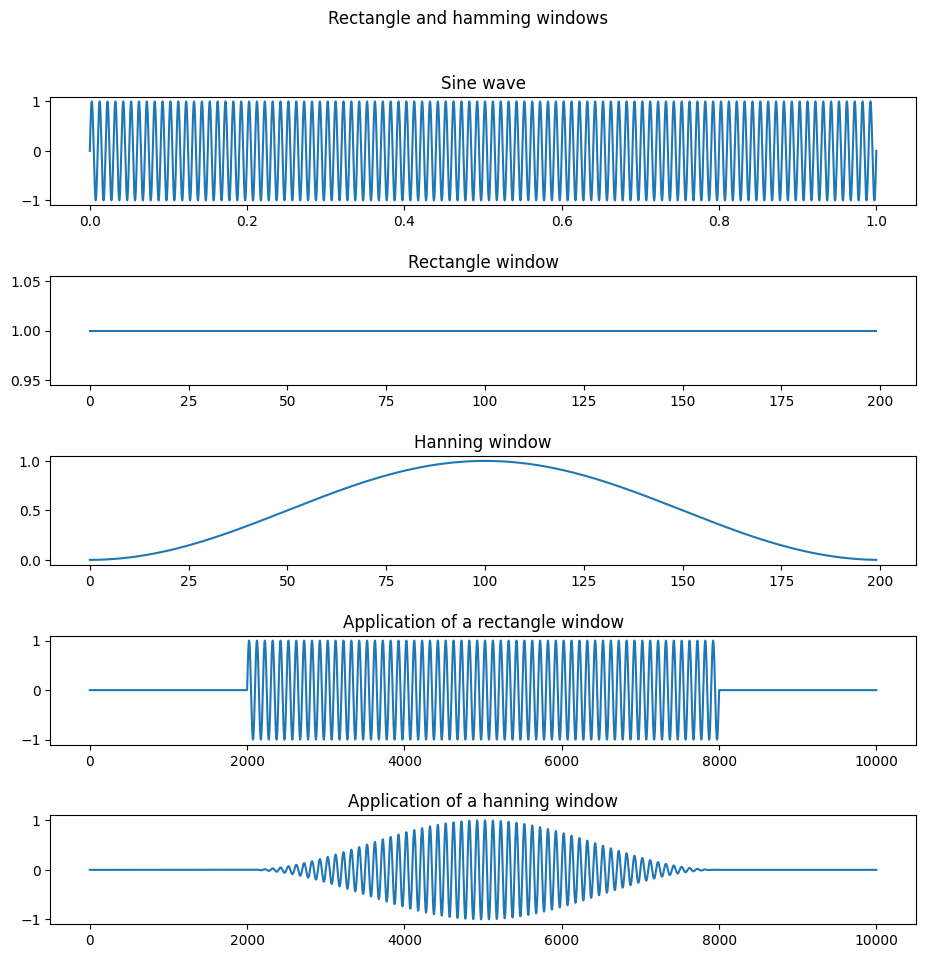

In [20]:
# Using hamming and rectangle windows over a sine signal.

def get_rectangle(n):
    return np.ones(n)

def get_hanning(n):
    values = 2*np.pi *  np.arange(0, n, 1) / n
    return 0.5 * (1- np.cos(values))

fig, axs = plt.subplots(5, figsize=(10,10))
fig.suptitle("Rectangle and hamming windows")
fig.tight_layout(pad=3)

f = 100
sine_wave = lambda t: np.sin(2 * np.pi * t * 100) 
time = np.linspace(0, 1,  10000)

rect_window = np.concatenate((np.zeros(2000), get_rectangle(6000), np.zeros(2000)), axis=0)
hann_window = np.concatenate((np.zeros(2000), get_hanning(6000), np.zeros(2000)), axis=0)

axs[0].set_title("Sine wave")
axs[0].plot(time, sine_wave(time))
axs[1].set_title("Rectangle window")
axs[1].plot(get_rectangle(200))
axs[2].set_title("Hanning window")
axs[2].plot(get_hanning(200))
axs[3].set_title("Application of a rectangle window")
axs[3].plot(np.multiply(sine_wave(time), rect_window))
axs[4].set_title("Application of a hanning window")
axs[4].plot(np.multiply(sine_wave(time), hann_window))


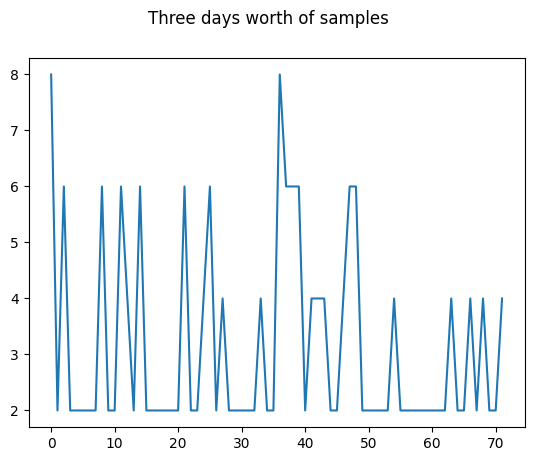

In [21]:
# Sampling three days worth of data.
fig, axs = plt.subplots(1)
fig.suptitle("Three days worth of samples")
x = pandas.read_csv("Train.csv")

start = 0 
per_day = 24
x = x[start:start+3*per_day] 

samples = x["Count"]
axs.plot(samples)

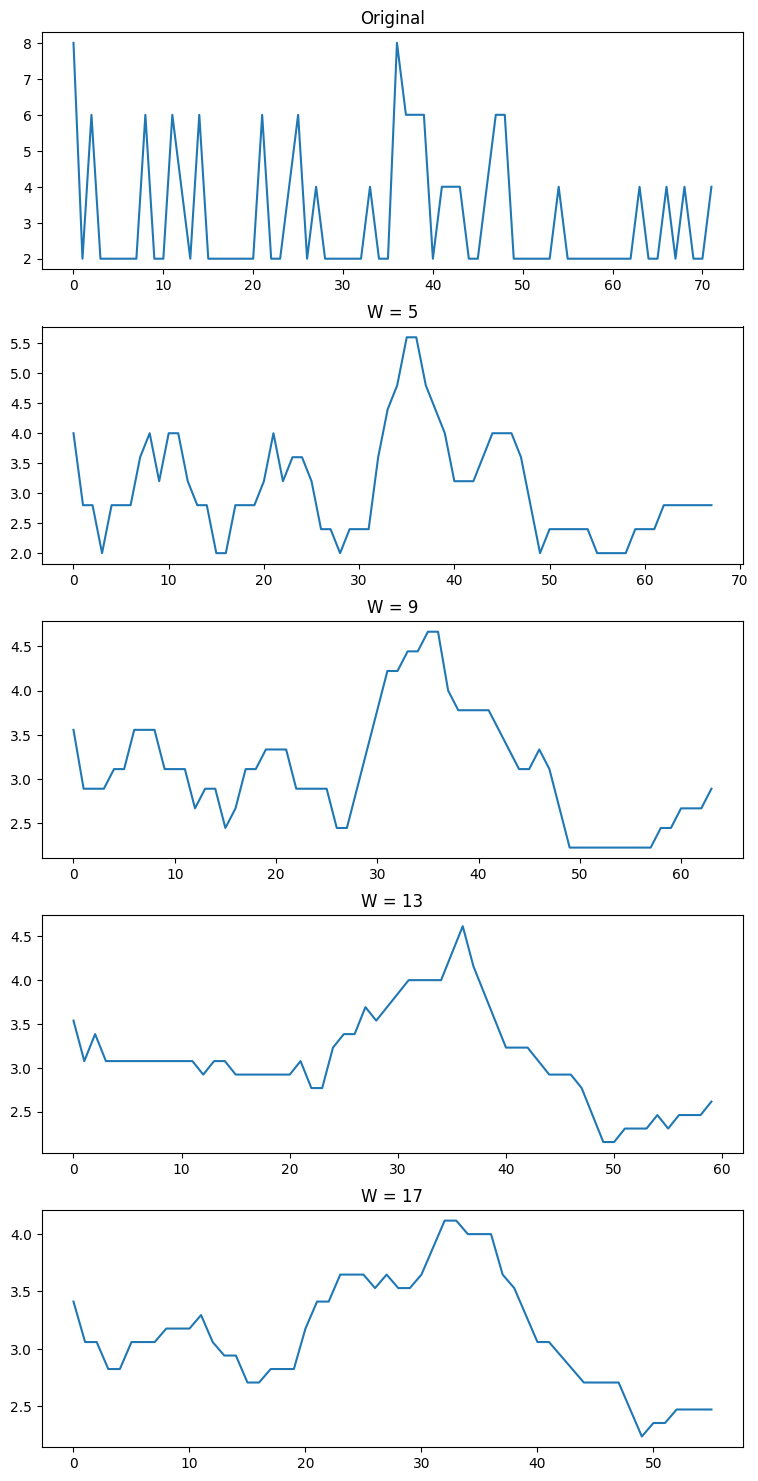

In [22]:
# Passing the signal through a mean-filter.
fig, axs = plt.subplots(5, figsize=(8,15))
fig.tight_layout(pad=2)

axs[0].set_title("Original")
axs[0].plot(samples)

ws = [5, 9, 13, 17]
for i,w in enumerate(ws):
    axs[i+1].set_title(f"W = {w}")
    window = np.ones(w) / w

    axs[i+1].plot(np.convolve(samples, window, 'valid'))



In [23]:
# Choosing which frequencies we are going to filter. 

# First compute the sampling frequency.
N = len(samples)

date_format = "%d-%m-%Y %H:%M"
first_date = dt.datetime.strptime(x["Datetime"][start], date_format)
last_date = dt.datetime.strptime(x["Datetime"][start+N-1], date_format)

interval = ((last_date-first_date).days + 1) * 24 * 3600
frequency = N/interval
print(f"The frequency is {frequency}")

# The niquist frequency is half the sampling frequency.
nyquist_frequency = frequency/2
print("The nyquist frequency is ", nyquist_frequency)

# Cut from
cut_frequency = 0.00007
nyquist_normalised = cut_frequency/nyquist_frequency
print(nyquist_normalised)


The frequency is 0.0002777777777777778
The nyquist frequency is  0.0001388888888888889
0.504


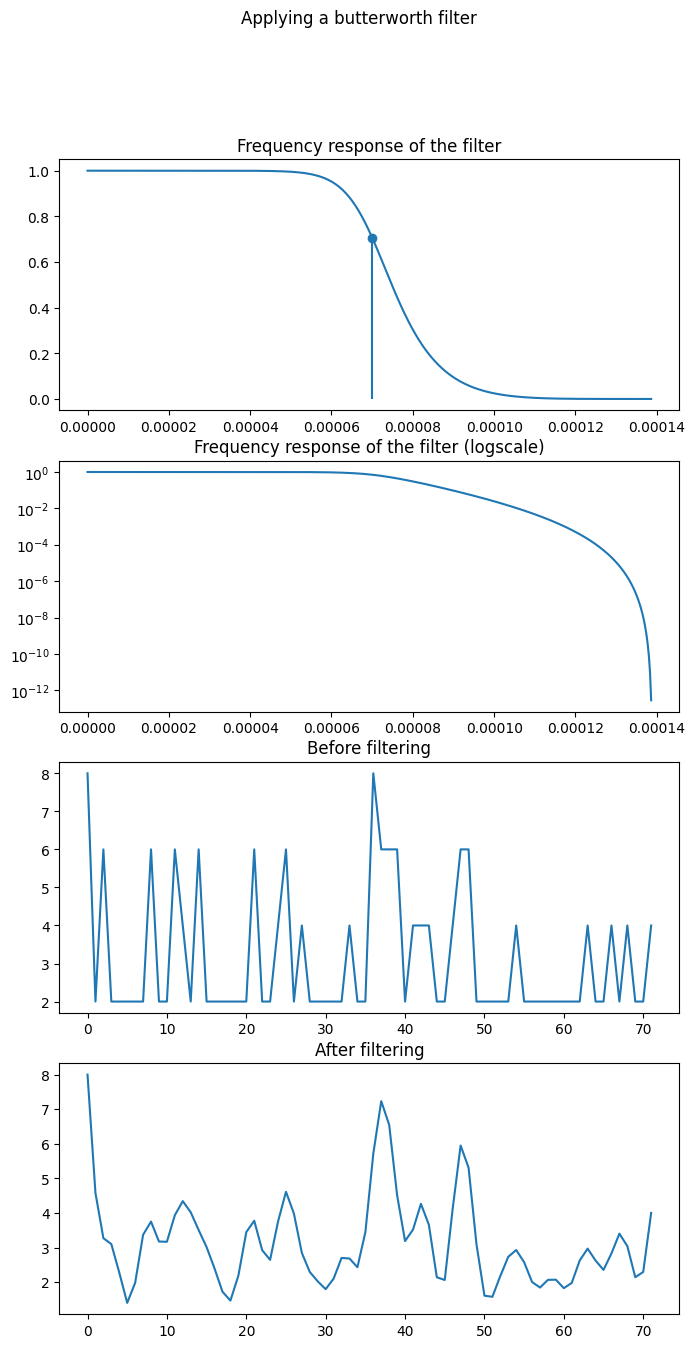

In [24]:
# Butterworth filter
fig, axs = plt.subplots(4, figsize=(8,15))
fig.suptitle("Applying a butterworth filter")

(b, a)= scipy.signal.butter(5, cut_frequency, fs=frequency,btype="lowpass")
w, h = scipy.signal.freqz(b, a, fs=frequency)
_, cut = scipy.signal.freqz(b, a, fs=frequency, worN= [cut_frequency] )

axs[0].set_title("Frequency response of the filter")
axs[0].plot(w, abs(h))
axs[0].stem([cut_frequency], [abs(cut)])

axs[1].set_title("Frequency response of the filter (logscale)")
axs[1].plot(w, abs(h))
axs[1].set_yscale("log")

axs[2].set_title("Before filtering")
axs[2].plot(samples)

axs[3].set_title("After filtering")
filtered = scipy.signal.filtfilt(b, a, samples)
axs[3].plot(filtered)

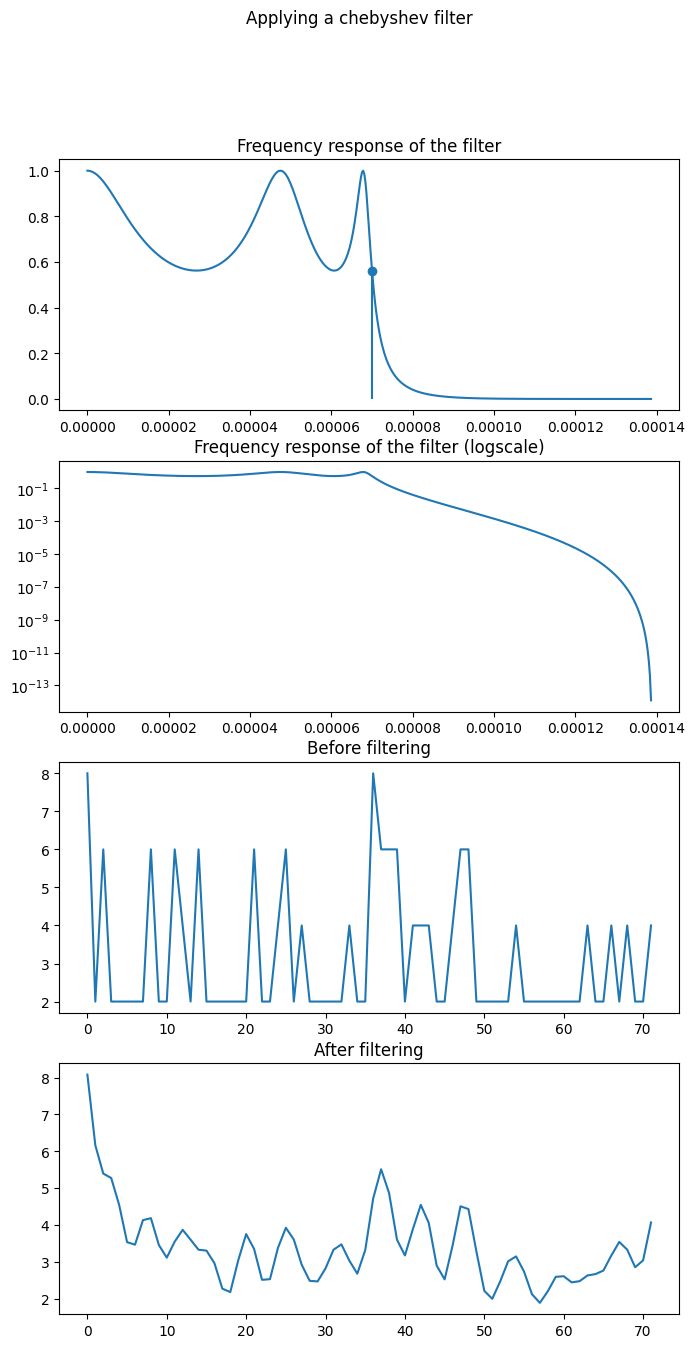

In [25]:
# Chebyshev filter
fig, axs = plt.subplots(4, figsize=(8,15))
fig.suptitle("Applying a chebyshev filter")

rp =  5 
(b, a)= scipy.signal.cheby1(5, rp, cut_frequency, fs=frequency,btype="lowpass")
w, h = scipy.signal.freqz(b, a, fs=frequency)
_, cut = scipy.signal.freqz(b, a, fs=frequency, worN= [cut_frequency] )

axs[0].set_title("Frequency response of the filter")
axs[0].plot(w, abs(h))
axs[0].stem([cut_frequency], [abs(cut)])

axs[1].set_title("Frequency response of the filter (logscale)")
axs[1].plot(w, abs(h))
axs[1].set_yscale("log")

axs[2].set_title("Before filtering")
axs[2].plot(samples)

axs[3].set_title("After filtering")
filtered = scipy.signal.filtfilt(b, a, samples)
axs[3].plot(filtered)

In [14]:
# I would choose the butterworth filter, because it does not affect the amplitude of the signal.
# The attenuation of the unwanted frequencies is not a strong as for the chebyshev filter, but
# I think that the amplitude matters more.

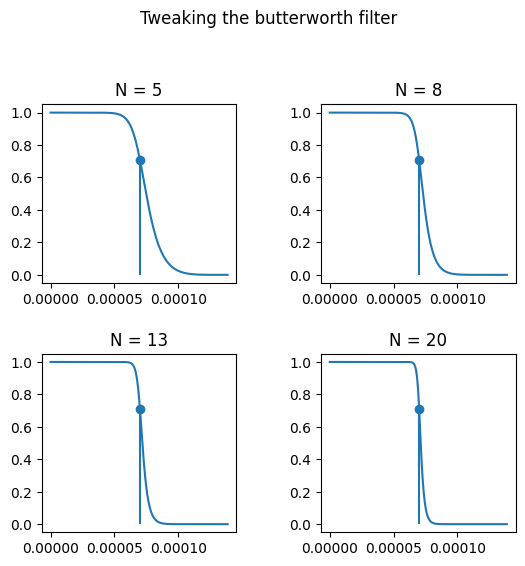

In [26]:
# Tweaking the butterworth filter.

fig, axs = plt.subplots(2,2 ,figsize=(6,6))
fig.suptitle("Tweaking the butterworth filter")
fig.tight_layout(pad=3)

ords = [5, 8, 13, 20]

for (i, o) in enumerate(ords):
    (b, a)= scipy.signal.butter(o, cut_frequency, fs=frequency,btype="lowpass")
    w, h = scipy.signal.freqz(b, a, fs=frequency)
    _, cut = scipy.signal.freqz(b, a, fs=frequency, worN= [cut_frequency] )
    axs[i//2, i%2].set_title(f"N = {o}")
    axs[i//2 , i%2].plot(w, abs(h))
    axs[i//2, i%2].stem([cut_frequency], [abs(cut)])

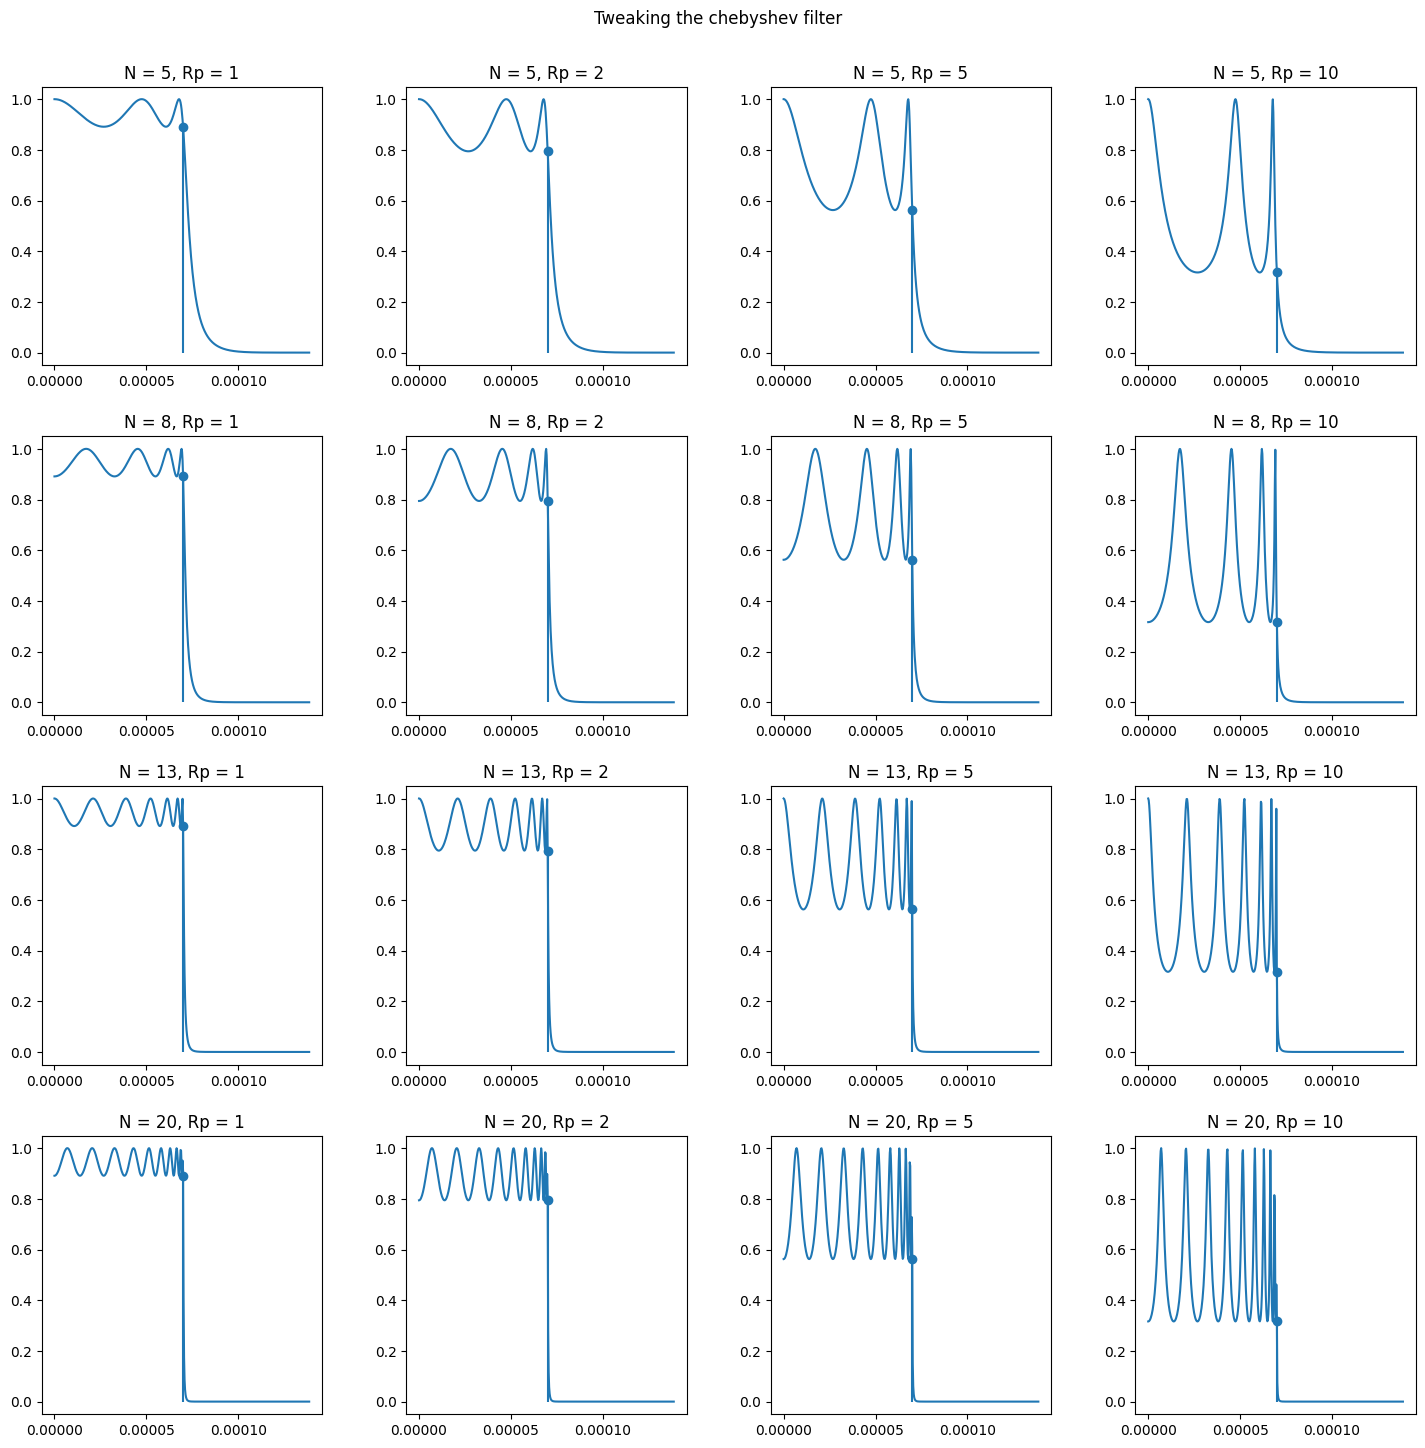

In [27]:
fig, axs = plt.subplots(4, 4, figsize=(15,15))
fig.suptitle("Tweaking the chebyshev filter")
fig.tight_layout(pad=3)

ords = [5, 8, 13, 20]
rps = [1, 2, 5, 10]

for (i, o) in enumerate(ords):
    for(j, rp) in enumerate(rps):
        (b, a)= scipy.signal.cheby1(o, rp, cut_frequency, fs=frequency,btype="lowpass")
        w, h = scipy.signal.freqz(b, a, fs=frequency)
        _, cut = scipy.signal.freqz(b, a, fs=frequency, worN= [cut_frequency] )

        axs[i,j].set_title(f"N = {o}, Rp = {rp}")
        axs[i,j].plot(w, abs(h))
        axs[i,j].stem([cut_frequency], [abs(cut)])
